# 準備

In [ ]:
# ファイルの読み込み
BASE_DIR = ''

## imports
import struct
import numpy as np

## 目的変数
with open(f'{BASE_DIR}/data/ptruv_2km_80-85.grd', 'rb') as f:
  s_list = []
  while True:
    b = f.read(18000)
    if len(b)==0:
      break
    s = np.array(struct.unpack('>4500f', b), dtype='float32')
    s_list.append(s)
y = np.array(s_list, dtype='float32')
del b, s, s_list

## 説明変数
with open(f'{BASE_DIR}/data/ptruv_5-2km_80-85.grd', 'rb') as f:
  s_list = []
  while True:
    b = f.read(18000)
    if len(b)==0:
      break
    s = np.array(struct.unpack('>4500f', b), dtype='float32')
    s_list.append(s)
x = np.array(s_list, dtype='float32')
del b, s, s_list

In [ ]:
# Copyright (c) 2020 Yoshiki Kato
!pip install git+https://github.com/Yoshiki443/weather_parameters
!pip install japanize-matplotlib

# imports
import wxparams as wx
import japanize_matplotlib
import tensorflow as tf
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
import os
import random
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Conv2D, Permute, Dense, BatchNormalization, MaxPooling2D
from keras.layers import concatenate, LeakyReLU, add, PReLU, GlobalAveragePooling2D, Multiply#, UpSampling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, classification_report

In [ ]:
# 学習の様子をプロットする関数
def plot_learning_process(title: str, loss, val_loss):
  plt.plot(range(1, len(loss)+1), loss, label='loss')
  plt.plot(range(1, len(val_loss)+1), val_loss, label='val_loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss(log)')
  plt.yscale('log')
  plt.title(title)
  plt.legend()
  plt.show()

In [ ]:
# モデルの評価を計算から表示まで実行するクラス
class Evaluation():
  def __init__(self, x, true, pred):

    ## 入力データと正解データ、出力データをクラスの属性として定義しておく
    self.x = x
    self.true = true
    self.pred = pred

    ## 負の降水を0にする
    self.pred[:,:900] = np.where(self.pred[:,:900]<0., 0., self.pred[:,:900])

    ## 風速、風向の列を追加
    W_x,D_x = wx.UV_to_SpdDir(self.x[:,2700:3600], self.x[:,3600:])
    self.x = np.concatenate([self.x, W_x, D_x], axis=1)
    W_t,D_t = wx.UV_to_SpdDir(self.true[:,2700:3600], self.true[:,3600:])
    self.true = np.concatenate([self.true, W_t, D_t], axis=1)
    W_p,D_p = wx.UV_to_SpdDir(self.pred[:,2700:3600], self.pred[:,3600:])
    self.pred = np.concatenate([self.pred, W_p, D_p], axis=1)

    ## metrics matrix
    self.MM = pd.DataFrame(np.zeros((29, 2)), columns=['Input', 'Pred'])
    self.MM.index = ['CORR_P', 'RMSE_CPT', 'RMSE_CPR', 'RMSE_XPT', 'RMSE_XPR', 'RMSE_999', 'RMSE_10', 'RMSE_4', 'RMSE_0.1', #8
                     'CORR_T', 'RMSE_AT', #10
                     'CORR_R', 'RMSE_AR', #12
                     'CORR_U', 'RMSE_AU', 'RMSE_XUT+', 'RMSE_XUT-', 'RMSE_XUR+', 'RMSE_XUR-', #18
                     'CORR_V', 'RMSE_AV', 'RMSE_XVT+', 'RMSE_XVT-', 'RMSE_XVR+', 'RMSE_XVR-', #24
                     'CORR_W', 'RMSE_AW', 'RMSE_XWT', 'RMSE_XWR']#28

    ## CORR
    for i,idx in enumerate(self.MM.index[[0,9,11,13,19,25]]):
      self.MM['Input'][idx] = self.corr(self.x[:,900*i:900*(i+1)].reshape(-1), self.true[:,900*i:900*(i+1)].reshape(-1))
      self.MM['Pred'][idx] = self.corr(self.pred[:,900*i:900*(i+1)].reshape(-1), self.true[:,900*i:900*(i+1)].reshape(-1))

    ## RMSE_A○
    for i,idx in enumerate(self.MM.index[[10,12,14,20,26]]):
      self.MM['Input'][idx] = self.rmse(self.x[:,900*(i+1):900*(i+2)], self.true[:,900*(i+1):900*(i+2)])
      self.MM['Pred'][idx] = self.rmse(self.pred[:,900*(i+1):900*(i+2)], self.true[:,900*(i+1):900*(i+2)])

    ## RMSE_X○T,X○T+
    for i,idx in enumerate(self.MM.index[[15,21,27]]):
      self.MM['Input'][idx] = self.rmse(self.x[:,900*(i+3):900*(i+4)].max(axis=0), self.true[:,900*(i+3):900*(i+4)].max(axis=0))
      self.MM['Pred'][idx] = self.rmse(self.pred[:,900*(i+3):900*(i+4)].max(axis=0), self.true[:,900*(i+3):900*(i+4)].max(axis=0))
    self.MM['Input'][3] = self.rmse(self.x[:,900*(i+3):900*(i+4)].max(axis=0), self.true[:,900*(i+3):900*(i+4)].max(axis=0))
    self.MM['Pred'][3] = self.rmse(self.pred[:,900*(i+3):900*(i+4)].max(axis=0), self.true[:,900*(i+3):900*(i+4)].max(axis=0))
    
    ## RMSE_X○R,X○R+
    for i,idx in enumerate(self.MM.index[[17,23,28]]):
      self.MM['Input'][idx] = self.rmse(self.x[:,900*(i+3):900*(i+4)].max(axis=1), self.true[:,900*(i+3):900*(i+4)].max(axis=1))
      self.MM['Pred'][idx] = self.rmse(self.pred[:,900*(i+3):900*(i+4)].max(axis=1), self.true[:,900*(i+3):900*(i+4)].max(axis=1))
    self.MM['Input'][4] = self.rmse(self.x[:,900*(i+3):900*(i+4)].max(axis=1), self.true[:,900*(i+3):900*(i+4)].max(axis=1))
    self.MM['Pred'][4] = self.rmse(self.pred[:,900*(i+3):900*(i+4)].max(axis=1), self.true[:,900*(i+3):900*(i+4)].max(axis=1))
    
    ## RMSE_X○T-
    for i,idx in enumerate(self.MM.index[[16,22]]):
      self.MM['Input'][idx] = self.rmse(self.x[:,900*(i+3):900*(i+4)].min(axis=0), self.true[:,900*(i+3):900*(i+4)].min(axis=0))
      self.MM['Pred'][idx] = self.rmse(self.pred[:,900*(i+3):900*(i+4)].min(axis=0), self.true[:,900*(i+3):900*(i+4)].min(axis=0))
      
    ## RMSE_X○R-
    for i,idx in enumerate(self.MM.index[[18,24]]):
      self.MM['Input'][idx] = self.rmse(self.x[:,900*(i+3):900*(i+4)].min(axis=1), self.true[:,900*(i+3):900*(i+4)].min(axis=1))
      self.MM['Pred'][idx] = self.rmse(self.pred[:,900*(i+3):900*(i+4)].min(axis=1), self.true[:,900*(i+3):900*(i+4)].min(axis=1))

    ## RMSE_CPT,CPR
    self.MM['Input'][1] = self.rmse(self.x[:,:900].sum(axis=0), self.true[:,:900].sum(axis=0))
    self.MM['Pred'][1] = self.rmse(self.pred[:,:900].sum(axis=0), self.true[:,:900].sum(axis=0))
    self.MM['Input'][2] = self.rmse(self.x[:,:900].sum(axis=1), self.true[:,:900].sum(axis=1))
    self.MM['Pred'][2] = self.rmse(self.pred[:,:900].sum(axis=1), self.true[:,:900].sum(axis=1))

    ## RMSE_999
    self.MM['Input'][5] = self.rmse(np.percentile(self.x[:,:900], q=99.9, axis=0), np.percentile(self.true[:,:900], q=99.9, axis=0))
    self.MM['Pred'][5] = self.rmse(np.percentile(self.pred[:,:900], q=99.9, axis=0), np.percentile(self.true[:,:900], q=99.9, axis=0))
    
    ## RMSE_○
    self.MM['Input'][6] = self.rmse(np.count_nonzero(self.x[:,:900]>10.0, axis=0)/len(self.true), np.count_nonzero(self.true[:,:900]>10.0, axis=0)/len(self.true))
    self.MM['Pred'][6] = self.rmse(np.count_nonzero(self.pred[:,:900]>10.0, axis=0)/len(self.true), np.count_nonzero(self.true[:,:900]>10.0, axis=0)/len(self.true))
    self.MM['Input'][7] = self.rmse(np.count_nonzero(self.x[:,:900]>4.0, axis=0)/len(self.true), np.count_nonzero(self.true[:,:900]>4.0, axis=0)/len(self.true))
    self.MM['Pred'][7] = self.rmse(np.count_nonzero(self.pred[:,:900]>4.0, axis=0)/len(self.true), np.count_nonzero(self.true[:,:900]>4.0, axis=0)/len(self.true))
    self.MM['Input'][8] = self.rmse(np.count_nonzero(self.x[:,:900]>0.1, axis=0)/len(self.true), np.count_nonzero(self.true[:,:900]>0.1, axis=0)/len(self.true))
    self.MM['Pred'][8] = self.rmse(np.count_nonzero(self.pred[:,:900]>0.1, axis=0)/len(self.true), np.count_nonzero(self.true[:,:900]>0.1, axis=0)/len(self.true))


  def __call__(self, file_name):
    self.MM.to_csv(f'{BASE_DIR}/results/{file_name}')
    display(self.MM)


  def corr(self, pred, true):
    return np.corrcoef(pred, true)[0,1]


  def rmse(self, pred, true) -> float:
    return np.sqrt(((pred - true)**2).mean())

In [ ]:
class Graph():
  def __init__(self, title: str, net: str, seed: int):
    # タイトルの設定
    self.title = title
    self.net = net
    # seed値の設定
    self.seed = seed

  def __call__(self, pred, true):
    W,D = wx.UV_to_SpdDir(pred[:,2700:3600], pred[:,3600:])

    self.show_time_series(pred[:,:900].sum(axis=1), '積算降水量(mm)', 0, 50000)
    self.show_time_series(pred[:,900:1800].mean(axis=1) - 273.15, '平均気温(℃)', -13, 27)
    self.show_time_series(pred[:,1800:2700].mean(axis=1), '平均湿数(℃)', 0, 23)
    self.show_time_series(pred[:,2700:3600].mean(axis=1), '平均東西風(mm/s)', -7, 7)
    self.show_time_series(pred[:,3600:4500].mean(axis=1), '平均南北風(mm/s)', -7, 8)
    self.show_time_series(W.max(axis=1), '最大風速(mm/s)', 0, 17)
    self.make_sample_gif(pred[:,:900], true[:,:900], 'Precipitation')
    self.make_sample_gif(pred[:,900:1800], true[:,900:1800], 'Temperature')
    self.make_sample_gif(pred[:,1800:2700], true[:,1800:2700], 'RelativeHumidity')
    self.show_hist(pred, true)
    self.show_rmse_map(pred[:,:900], true[:,:900])
    self.show_rmse_map(pred[:,900:1800], true[:,900:1800])
    self.show_rmse_map(pred[:,1800:2700], true[:,1800:2700])
    self.show_me_map(pred[:,:900], true[:,:900], -2, 3)
    self.show_me_map(pred[:,900:1800], true[:,900:1800], -5, 5)
    self.show_me_map(pred[:,1800:2700], true[:,1800:2700], -4, 7)
    self.show_999tile_map(pred[:,:900], 0, 45)
    self.freq_map(pred[:,:900], 10.0, 0, 0.013)
    self.freq_map(pred[:,:900], 4.0, 0, 0.1)

  # 時系列のグラフ
  def show_time_series(self, pred, ylabel:str, ymin, ymax):
    plt.figure(figsize=(15,3))
    plt.plot(pred)
    plt.xticks(ticks=[0,2184,4344,6552,8760], labels=['1984/09/01', '1984/12/01', '1985/03/01', '1985/06/01', '1985/09/01'])
    plt.xlabel('Time(h)')
    plt.ylabel(ylabel)
    plt.ylim(ymin,ymax)
    plt.title(self.title)
    plt.show()

  # サンプルgif
  def make_sample_gif(self, pred, true, variable:str):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    pmin, pmax, ims = true[6454:6466,:].min(), true[6454:6466,:].max(), []
    for i in range(6454,6466):
      im = ax.imshow(pred[i,:].reshape((30,30))[::-1], cmap='jet', animated=True, vmin=pmin, vmax=pmax)
      if i==6454:
        cbar = fig.colorbar(im, ax=ax)
        cbar.min, cbar.max = pmin, pmax
      ax.set_xticks(ticks=[-0.5,9.5,19.5,29.5])
      ax.set_xticklabels(['137.8E','138.0E','138.2E','138.4E'])
      ax.set_yticks(ticks=[-0.5,9.5,19.5,29.5])
      ax.set_yticklabels(['35.5N','35.3N','35.1N','34.9N'])
      ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000)
    ani.save(f'{BASE_DIR}/images/sample{variable}_{self.net}_seed{self.seed}_85-5-27-23_85-5-28-10.gif', writer='pillow')

  # 降水量のヒストグラム
  def show_hist(self, pred, true):
    edges = range(-10, 170, 10)
    plt.figure(figsize=(3,2))
    plt.hist([pred[:,:900].reshape(-1), true[:,:900].reshape(-1)], bins=edges, rwidth=0.8)
    plt.yscale('log')
    plt.xlabel('Precipitation Per Hour(mm/h)')
    plt.ylabel('Frequency (log10)')
    plt.title(self.title)
    plt.show()

  # RMSEのマップ
  def show_rmse_map(self, pred, true):
    plt.figure(figsize=(3,2))
    plt.imshow(np.sqrt(((pred - true)**2).mean(axis=0)).reshape((30,30))[::-1], cmap='jet')
    plt.xticks(ticks=[-0.5,9.5,19.5,29.5], labels=['137.8E','138.0E','138.2E','138.4E'])
    plt.yticks(ticks=[-0.5,9.5,19.5,29.5], labels=['35.5N','35.3N','35.1N','34.9N'])
    plt.xlabel('Longitude(°)')
    plt.ylabel('Latitude(°)')
    plt.title(self.title)
    plt.colorbar()
    plt.show()

  # MEのマップ
  def show_me_map(self, pred, true, cmin, cmax):
    plt.figure(figsize=(3,2))
    plt.imshow((pred - true).mean(axis=0).reshape((30,30))[::-1], cmap='jet')
    plt.xticks(ticks=[-0.5,9.5,19.5,29.5], labels=['137.8E','138.0E','138.2E','138.4E'])
    plt.yticks(ticks=[-0.5,9.5,19.5,29.5], labels=['35.5N','35.3N','35.1N','34.9N'])
    plt.xlabel('Longitude(°)')
    plt.ylabel('Latitude(°)')
    plt.title(self.title)
    plt.colorbar()
    plt.clim(cmin,cmax)
    plt.show()
  
  # 99.9%タイル値のマップ
  def show_999tile_map(self, pred, cmin, cmax):
    plt.figure(figsize=(3,2))
    plt.imshow(np.percentile(pred, q=99.9, axis=0).reshape((30,30))[::-1], cmap='jet')
    plt.xticks(ticks=[-0.5,9.5,19.5,29.5], labels=['137.8E','138.0E','138.2E','138.4E'])
    plt.yticks(ticks=[-0.5,9.5,19.5,29.5], labels=['35.5N','35.3N','35.1N','34.9N'])
    plt.xlabel('Longitude(°)')
    plt.ylabel('Latitude(°)')
    plt.title(self.title)
    plt.colorbar()
    plt.clim(cmin,cmax)
    plt.show()

  # 発生頻度のマップ
  def freq_map(self, pred, threshold: float, cmin, cmax):
    plt.figure(figsize=(3,2))
    plt.imshow((np.count_nonzero(pred>threshold, axis=0) / len(pred)).reshape((30,30))[::-1], cmap='jet')
    plt.xticks(ticks=[-0.5,9.5,19.5,29.5], labels=['137.8E','138.0E','138.2E','138.4E'])
    plt.yticks(ticks=[-0.5,9.5,19.5,29.5], labels=['35.5N','35.3N','35.1N','34.9N'])
    plt.xlabel('Longitude(°)')
    plt.ylabel('Latitude(°)')
    plt.title(self.title)
    plt.colorbar()
    plt.clim(cmin,cmax)
    plt.show()

# MLP

In [ ]:
# データの分割と標準化
ss_x = StandardScaler()
x_train = np.transpose(ss_x.fit_transform(np.transpose(x[:-8760,:].copy().reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
x_test = np.transpose(ss_x.transform(np.transpose(x[-8760:,:].copy().reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
x_pred = x[-8760:,:].copy()
y_p = x[:-8760,:] - y[:-8760,:]
y_p[:,:900] = (x[:-8760,:900] - y[:-8760,:900] + 150)**3

ss_y = StandardScaler()
y_train = np.transpose(ss_y.fit_transform(np.transpose((y_p).reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
y_test = y[-8760:,:].copy()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [ ]:
# シード値関連の設定
seed = 0
initializer=keras.initializers.GlorotUniform(seed=seed) # 重みの初期化に使用

## 乱数シードを固定する関数
def set_seed(seed=0):
  os.environ['PYTHONHASHSEED'] = str(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

set_seed(seed)

Epoch 1/200
55/55 [==============================] - 7s 110ms/step - loss: 5147.1738 - val_loss: 1.0101
Epoch 2/200
55/55 [==============================] - 5s 100ms/step - loss: 1.0188 - val_loss: 1.0057
Epoch 3/200
55/55 [==============================] - 6s 101ms/step - loss: 1.0134 - val_loss: 1.0000
Epoch 4/200
55/55 [==============================] - 6s 100ms/step - loss: 1.0076 - val_loss: 0.9942
Epoch 5/200
55/55 [==============================] - 6s 100ms/step - loss: 1.0041 - val_loss: 0.9878
Epoch 6/200
55/55 [==============================] - 6s 101ms/step - loss: 0.9950 - val_loss: 0.9812
Epoch 7/200
55/55 [==============================] - 6s 100ms/step - loss: 0.9892 - val_loss: 0.9745
Epoch 8/200
55/55 [==============================] - 6s 102ms/step - loss: 0.9815 - val_loss: 0.9675
Epoch 9/200
55/55 [==============================] - 6s 102ms/step - loss: 0.9746 - val_loss: 0.9607
Epoch 10/200
55/55 [==============================] - 6s 102ms/step - loss: 0.9675 - val

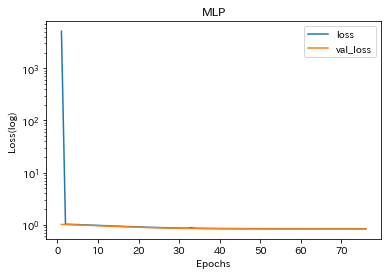

,Input,Pred
CORR_P,0.555495,0.555679
RMSE_CPT,1425.099121,255.539642
RMSE_CPR,873.349365,862.601868
RMSE_XPT,2.156741,1.823851
RMSE_XPR,1.194064,1.082768
RMSE_999,18.523600,18.378004
RMSE_10,0.006348,0.006316
RMSE_4,0.011122,0.010490
RMSE_0.1,0.018648,0.774772
CORR_T,0.988171,0.993991


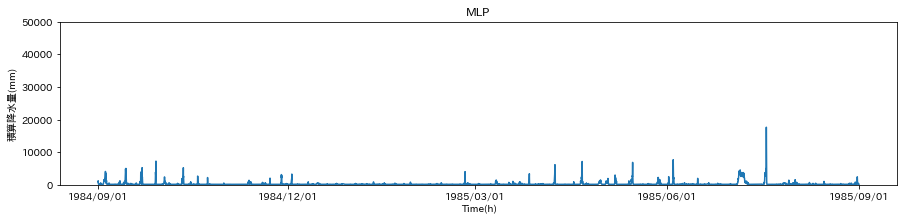

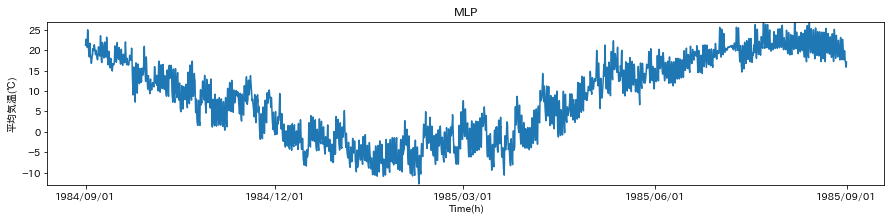

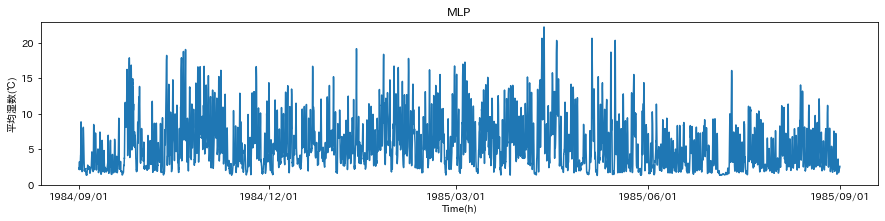

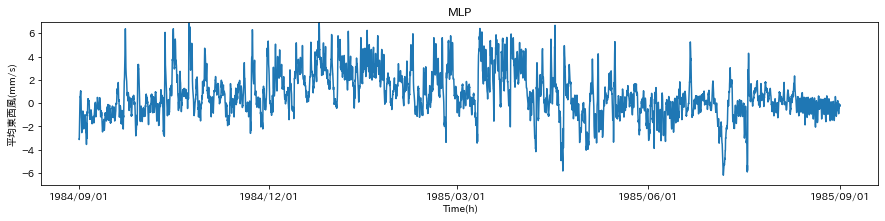

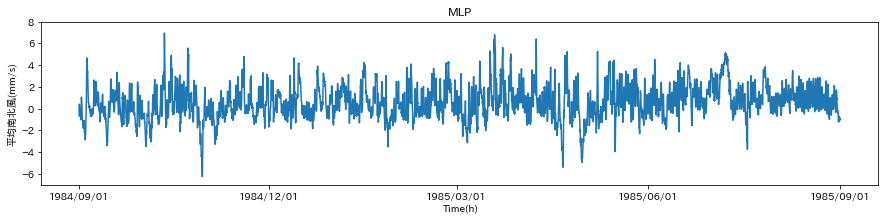

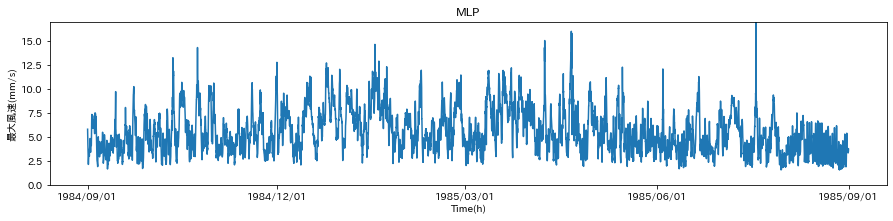

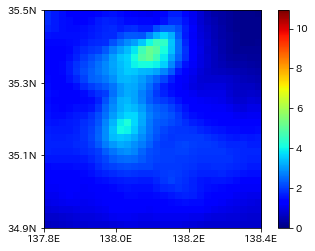

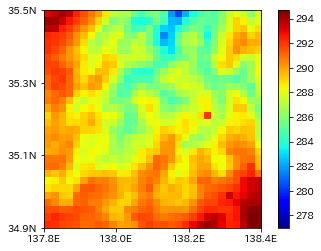

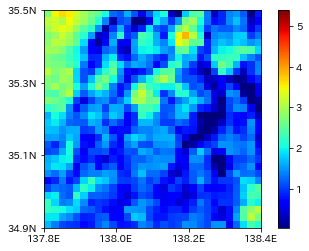

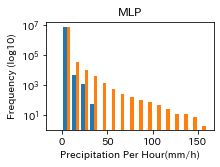

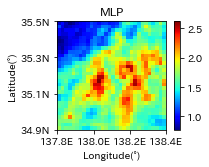

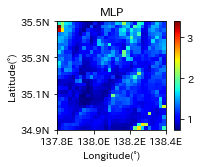

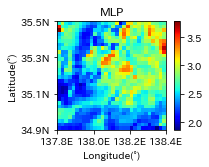

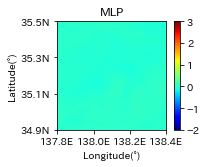

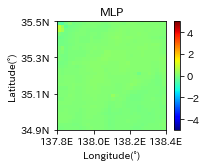

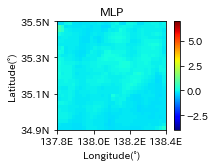

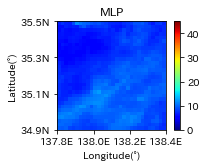

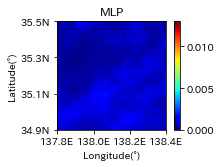

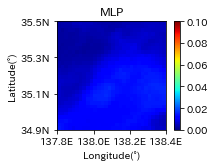

In [ ]:
# モデル構造の定義
inputs = Input(shape=(4500,))
z = Dense(8192, activation='relu', kernel_initializer=initializer)(inputs)
z = Dense(2048, activation='relu', kernel_initializer=initializer)(z)
outputs = Dense(4500, activation='linear', kernel_initializer=initializer)(z)

# モデルのインスタンス化
set_seed(seed)
model = Model(inputs=inputs, outputs=outputs)

# モデルのコンパイル
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

# モデルの学習
callbacks = [EarlyStopping(patience=5, monitor='val_loss')]
set_seed(seed)
history = model.fit(x=x_train, y=y_train, epochs=200, callbacks=callbacks, validation_data=(x_val, y_val), batch_size=512)

# 推論
pred = np.transpose(ss_y.inverse_transform(np.transpose(model.predict(x_test).reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
pred[:,900:] = x_pred[:,900:] - pred[:,900:]
pred[:,:900] = x_pred[:,:900] - np.cbrt(pred[:,:900]) + 150

# グラフのタイトル
title, net = 'MLP', 'MLP'

# 学習の様子をプロット
plot_learning_process(title, history.history['loss'], history.history['val_loss'])

# 学習データの評価
result = Evaluation(x_pred, y_test, pred)
result('result_MLP.csv')

# グラフの表示
Graph(title, net, seed=seed)(pred, y_test)

In [ ]:
with open(f'{BASE_DIR}/results/MLP.pickle', 'wb') as f:
  pickle.dump(pred, f)

# CNN①(SRCNN)

In [ ]:
# データの分割と標準化
ss_x = StandardScaler()
x_train = np.transpose(ss_x.fit_transform(np.transpose(x[:-8760,:].copy().reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
x_test = np.transpose(ss_x.transform(np.transpose(x[-8760:,:].copy().reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
x_pred = x[-8760:,:].copy()
y_p = x[:-8760,:] - y[:-8760,:]
y_p[:,:900] = (x[:-8760,:900] - y[:-8760,:900] + 150)**3

ss_y = StandardScaler()
y_train = np.transpose(ss_y.fit_transform(np.transpose((y_p).reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
y_test = y[-8760:,:].copy()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [ ]:
# シード値関連の設定
seed = 0
initializer=keras.initializers.GlorotUniform(seed=seed) # 重みの初期化に使用

## 乱数シードを固定する関数
def set_seed(seed=0):
  os.environ['PYTHONHASHSEED'] = str(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

set_seed(seed)

Epoch 1/200
55/55 [==============================] - 12s 100ms/step - loss: 0.8163 - val_loss: 0.7529
Epoch 2/200
55/55 [==============================] - 4s 82ms/step - loss: 0.7419 - val_loss: 0.7256
Epoch 3/200
55/55 [==============================] - 4s 81ms/step - loss: 0.7183 - val_loss: 0.7022
Epoch 4/200
55/55 [==============================] - 4s 81ms/step - loss: 0.7047 - val_loss: 0.6967
Epoch 5/200
55/55 [==============================] - 5s 82ms/step - loss: 0.6933 - val_loss: 0.6920
Epoch 6/200
55/55 [==============================] - 5s 82ms/step - loss: 0.6871 - val_loss: 0.6772
Epoch 7/200
55/55 [==============================] - 4s 82ms/step - loss: 0.6788 - val_loss: 0.6805
Epoch 8/200
55/55 [==============================] - 4s 82ms/step - loss: 0.6726 - val_loss: 0.6734
Epoch 9/200
55/55 [==============================] - 4s 82ms/step - loss: 0.6683 - val_loss: 0.6656
Epoch 10/200
55/55 [==============================] - 4s 82ms/step - loss: 0.6621 - val_loss: 0.66

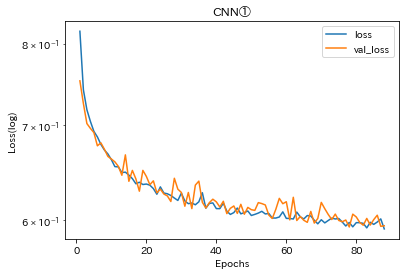

,Input,Pred
CORR_P,0.555495,0.602103
RMSE_CPT,1425.099121,486.420654
RMSE_CPR,873.349365,740.984131
RMSE_XPT,2.156741,1.699325
RMSE_XPR,1.194064,1.378403
RMSE_999,18.523600,16.320567
RMSE_10,0.006348,0.005344
RMSE_4,0.011122,0.005849
RMSE_0.1,0.018648,0.297295
CORR_T,0.988171,0.993521


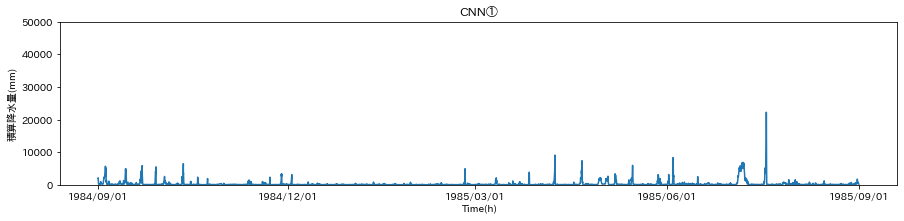

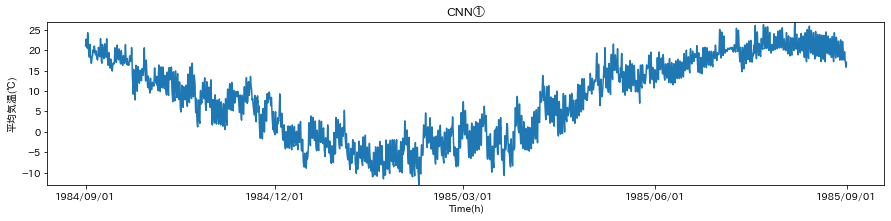

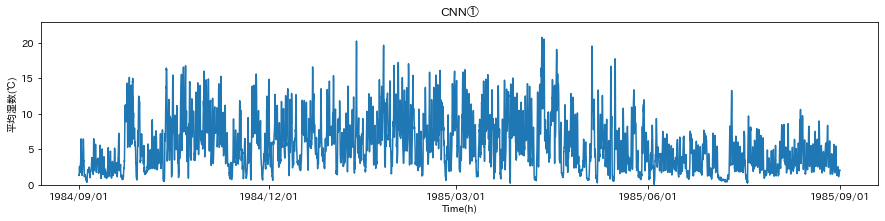

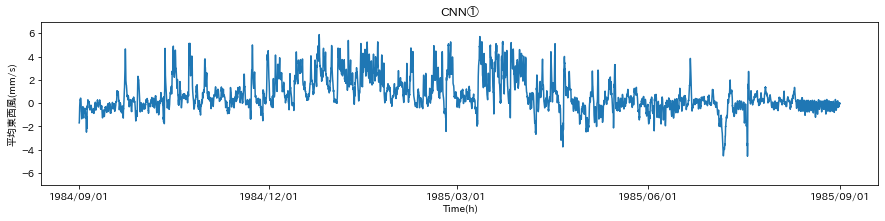

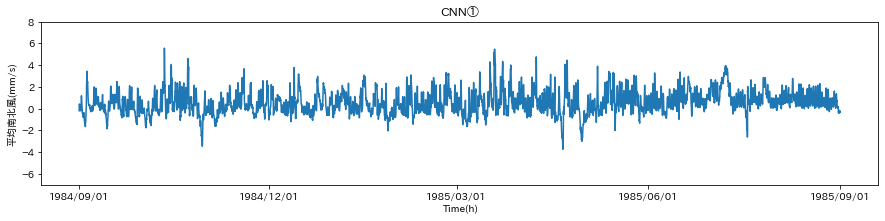

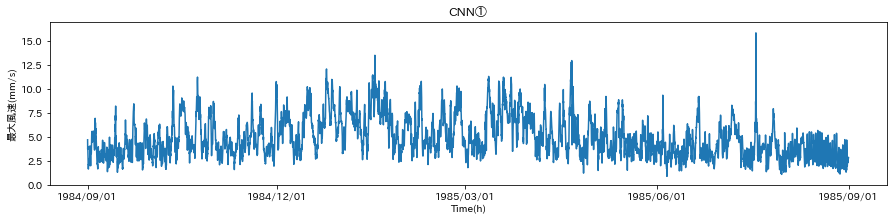

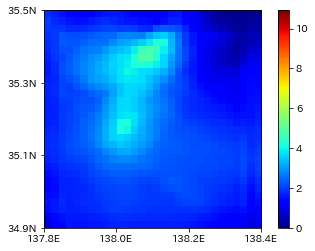

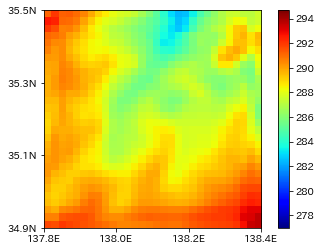

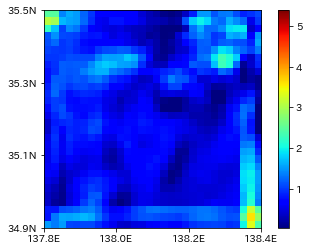

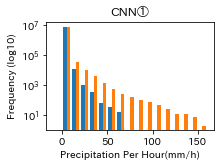

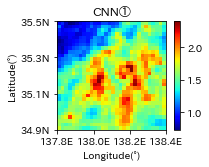

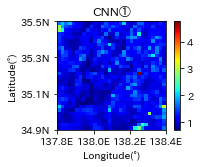

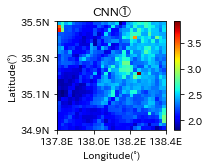

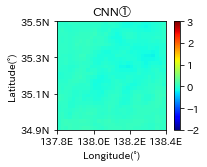

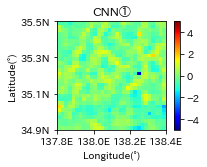

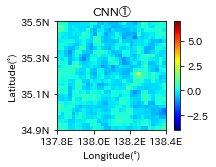

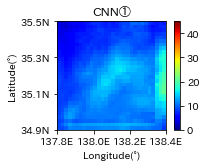

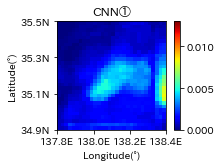

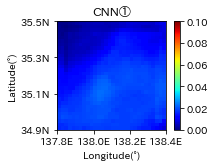

In [ ]:
# モデル構造の定義
inputs = Input(shape=(4500,))
z = Reshape((5, 30, 30))(inputs)
z = Permute((2,3,1))(z)
z = Conv2D(64, 5, activation='relu', padding='same', kernel_initializer=initializer)(z)
z = Conv2D(32, 1, activation='relu', padding='same', kernel_initializer=initializer)(z)
z = Conv2D(5, 3, activation='linear', padding='same', kernel_initializer=initializer)(z)
z = Permute((3,1,2))(z)
outputs = Reshape((4500,))(z)

# モデルのインスタンス化
set_seed(seed)
model = Model(inputs=inputs, outputs=outputs)

# モデルのコンパイル
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

# モデルの学習
callbacks = [EarlyStopping(patience=10, monitor='val_loss')]
set_seed(seed)
history = model.fit(x=x_train, y=y_train, epochs=200, callbacks=callbacks, validation_data=(x_val, y_val), batch_size=512)

# 推論
pred = np.transpose(ss_y.inverse_transform(np.transpose(model.predict(x_test).reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
pred[:,900:] = x_pred[:,900:] - pred[:,900:]
pred[:,:900] = x_pred[:,:900] - np.cbrt(pred[:,:900]) + 150

# グラフのタイトル
title, net = 'CNN①', 'SRCNN'

# 学習の様子をプロット
plot_learning_process(title, history.history['loss'], history.history['val_loss'])

# 学習データの評価
result = Evaluation(x_pred, y_test, pred)
result('result_SRCNN.csv')

# グラフの表示
Graph(title, net, seed=seed)(pred, y_test)

In [ ]:
with open(f'{BASE_DIR}/results/SRCNN.pickle', 'wb') as f:
  pickle.dump(pred, f)

# CNN②(UNet)

In [ ]:
# データの分割と標準化
ss_x = StandardScaler()
x_train = np.transpose(ss_x.fit_transform(np.transpose(x[:-8760,:].copy().reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
x_test = np.transpose(ss_x.transform(np.transpose(x[-8760:,:].copy().reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
x_pred = x[-8760:,:].copy()
y_p = x[:-8760,:] - y[:-8760,:]
y_p[:,:900] = (x[:-8760,:900] - y[:-8760,:900] + 150)**3

ss_y = StandardScaler()
y_train = np.transpose(ss_y.fit_transform(np.transpose((y_p).reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
y_test = y[-8760:,:].copy()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [ ]:
# シード値関連の設定
seed = 0
initializer=keras.initializers.GlorotUniform(seed=seed) # 重みの初期化に使用

## 乱数シードを固定する関数
def set_seed(seed=0):
  os.environ['PYTHONHASHSEED'] = str(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

set_seed(seed)

Epoch 1/200
55/55 [==============================] - 44s 662ms/step - loss: 1.2708 - val_loss: 1.8950
Epoch 2/200
55/55 [==============================] - 33s 594ms/step - loss: 0.8518 - val_loss: 0.8555
Epoch 3/200
55/55 [==============================] - 33s 596ms/step - loss: 0.7949 - val_loss: 0.8220
Epoch 4/200
55/55 [==============================] - 33s 598ms/step - loss: 0.7602 - val_loss: 0.7934
Epoch 5/200
55/55 [==============================] - 33s 598ms/step - loss: 0.7241 - val_loss: 0.7453
Epoch 6/200
55/55 [==============================] - 33s 598ms/step - loss: 0.6996 - val_loss: 0.7272
Epoch 7/200
55/55 [==============================] - 33s 598ms/step - loss: 0.6706 - val_loss: 0.7021
Epoch 8/200
55/55 [==============================] - 33s 598ms/step - loss: 0.6415 - val_loss: 0.6870
Epoch 9/200
55/55 [==============================] - 33s 597ms/step - loss: 0.6184 - val_loss: 0.6490
Epoch 10/200
55/55 [==============================] - 33s 598ms/step - loss: 0.590

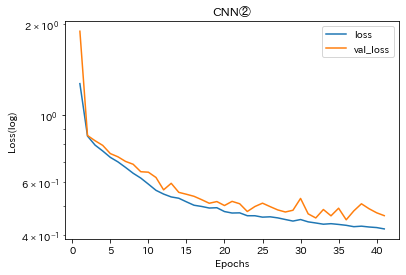

,Input,Pred
CORR_P,0.555495,0.633932
RMSE_CPT,1425.099121,475.218079
RMSE_CPR,873.349365,675.579590
RMSE_XPT,2.156741,1.814525
RMSE_XPR,1.194064,1.119943
RMSE_999,18.523600,14.196468
RMSE_10,0.006348,0.003592
RMSE_4,0.011122,0.004021
RMSE_0.1,0.018648,0.215305
CORR_T,0.988171,0.996256


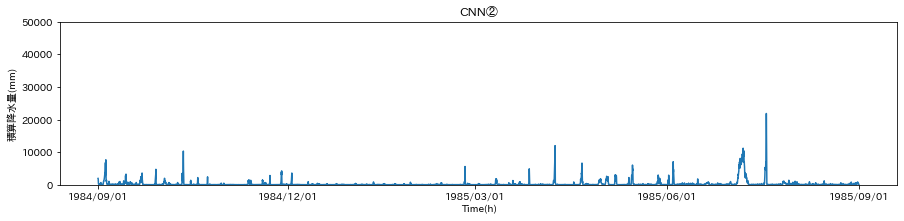

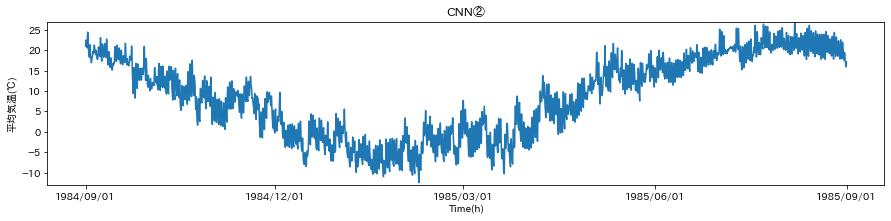

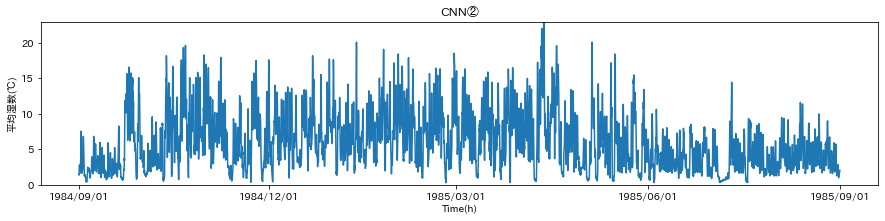

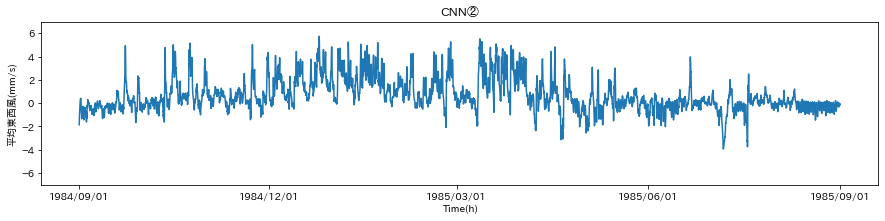

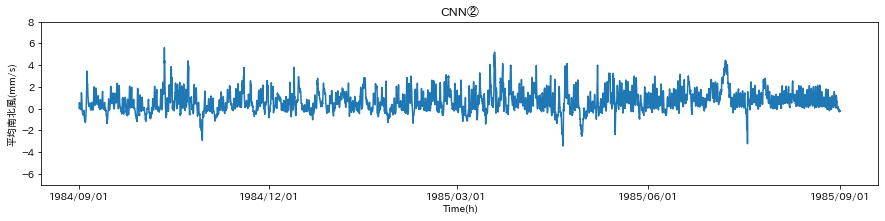

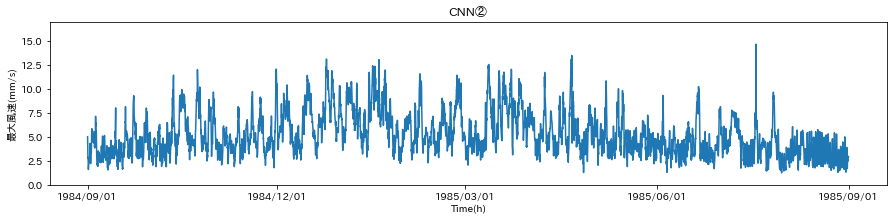

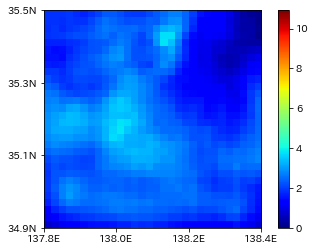

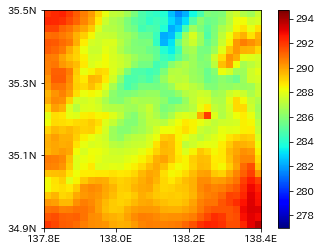

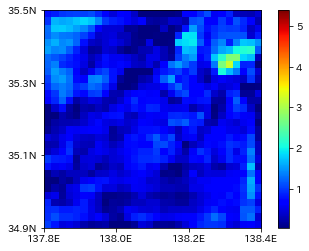

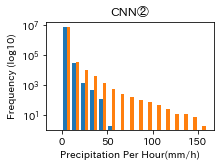

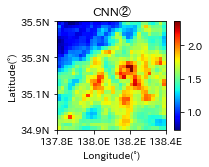

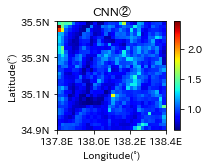

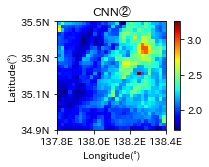

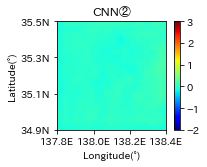

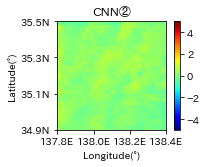

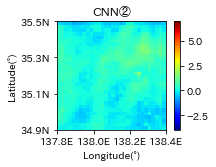

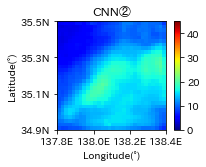

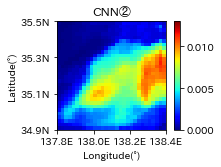

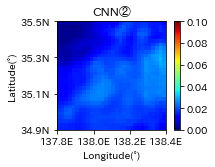

In [ ]:
# モデル構造の定義
inputs = Input(shape=(4500,))
enc1 = Reshape((5, 30, 30))(inputs)
enc1 = Permute((2,3,1))(enc1)
enc1 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=initializer)(enc1)
enc1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(enc1)
enc1 = Conv2D(64, 3, padding='same', kernel_initializer=initializer)(enc1)
enc1 = BatchNormalization(axis=-1)(enc1)
enc1 = LeakyReLU(alpha=0.01)(enc1)
enc1_pool = MaxPooling2D((2,2), strides=None)(enc1)

enc2 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=initializer)(enc1_pool)
enc2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=initializer)(enc2)
enc2 = Conv2D(512, 3, padding='same', kernel_initializer=initializer)(enc2)
enc2 = BatchNormalization(axis=-1)(enc2)
enc2 = LeakyReLU(alpha=0.01)(enc2)

dec2 = tf.nn.depth_to_space(enc2, 2)
dec2 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=initializer)(dec2)
dec2 = concatenate([dec2, enc1], axis=-1)
dec2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(dec2)
dec2 = Conv2D(64, 3, padding='same', kernel_initializer=initializer)(dec2)
dec2 = BatchNormalization(axis=-1)(dec2)
dec2 = LeakyReLU(alpha=0.01)(dec2)
dec2 = Conv2D(5, 3, activation='linear', padding='same', kernel_initializer=initializer)(dec2)
dec2 = Permute((3,1,2))(dec2)
outputs = Reshape((4500,))(dec2)

# モデルのインスタンス化
set_seed(seed)
model = Model(inputs=inputs, outputs=outputs)

# モデルのコンパイル
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

# モデルの学習
callbacks = [EarlyStopping(patience=5, monitor='val_loss')]
set_seed(seed)
history = model.fit(x=x_train, y=y_train, epochs=200, callbacks=callbacks, validation_data=(x_val, y_val), batch_size=512)

# 推論
pred = np.transpose(ss_y.inverse_transform(np.transpose(model.predict(x_test).reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
pred[:,900:] = x_pred[:,900:] - pred[:,900:]
pred[:,:900] = x_pred[:,:900] - np.cbrt(pred[:,:900]) + 150

# グラフのタイトル
title, net = 'CNN②', 'UNet'

# 学習の様子をプロット
plot_learning_process(title, history.history['loss'], history.history['val_loss'])

# 学習データの評価
result = Evaluation(x_pred, y_test, pred)
result('result_UNet.csv')

# グラフの表示
Graph(title, net, seed=seed)(pred, y_test)

In [ ]:
with open(f'{BASE_DIR}/results/UNet.pickle', 'wb') as f:
  pickle.dump(pred, f)

# CNN③(SE-SRResNet)

In [ ]:
# データの分割と標準化
ss_x = StandardScaler()
x_train = np.transpose(ss_x.fit_transform(np.transpose(x[:-8760,:].copy().reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
x_test = np.transpose(ss_x.transform(np.transpose(x[-8760:,:].copy().reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
x_pred = x[-8760:,:].copy()
y_p = x[:-8760,:] - y[:-8760,:]
y_p[:,:900] = (x[:-8760,:900] - y[:-8760,:900] + 150)**3

ss_y = StandardScaler()
y_train = np.transpose(ss_y.fit_transform(np.transpose((y_p).reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
y_test = y[-8760:,:].copy()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [ ]:
# シード値関連の設定
seed = 0
initializer=keras.initializers.GlorotUniform(seed=seed) # 重みの初期化に使用

## 乱数シードを固定する関数
def set_seed(seed=0):
  os.environ['PYTHONHASHSEED'] = str(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

set_seed(seed)

Epoch 1/200
55/55 [==============================] - 35s 539ms/step - loss: 1.3118 - val_loss: 21205.8652
Epoch 2/200
55/55 [==============================] - 29s 523ms/step - loss: 0.6506 - val_loss: 453.5681
Epoch 3/200
55/55 [==============================] - 29s 524ms/step - loss: 0.6056 - val_loss: 9.4871
Epoch 4/200
55/55 [==============================] - 29s 526ms/step - loss: 0.5768 - val_loss: 0.6966
Epoch 5/200
55/55 [==============================] - 29s 526ms/step - loss: 0.5550 - val_loss: 0.5677
Epoch 6/200
55/55 [==============================] - 29s 526ms/step - loss: 0.5561 - val_loss: 0.5450
Epoch 7/200
55/55 [==============================] - 29s 526ms/step - loss: 0.5488 - val_loss: 0.5491
Epoch 8/200
55/55 [==============================] - 29s 526ms/step - loss: 0.5313 - val_loss: 0.5293
Epoch 9/200
55/55 [==============================] - 29s 527ms/step - loss: 0.5313 - val_loss: 0.5246
Epoch 10/200
55/55 [==============================] - 29s 526ms/step - loss:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in power


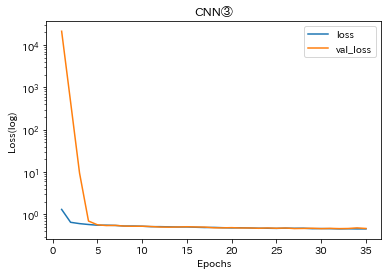

,Input,Pred
CORR_P,0.555495,NaN
RMSE_CPT,1425.099121,NaN
RMSE_CPR,873.349365,NaN
RMSE_XPT,2.156741,1.799012
RMSE_XPR,1.194064,1.001081
RMSE_999,18.523600,NaN
RMSE_10,0.006348,0.002878
RMSE_4,0.011122,0.004252
RMSE_0.1,0.018648,0.437043
CORR_T,0.988171,0.996366


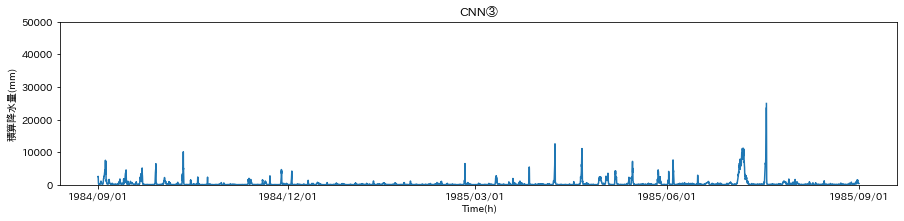

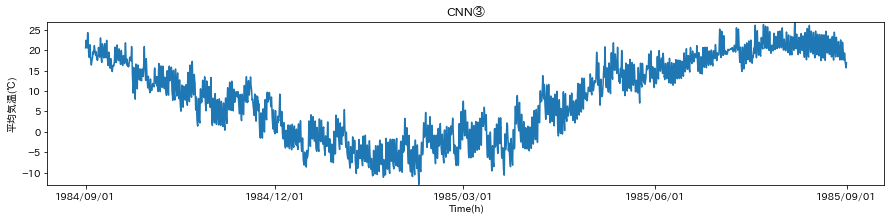

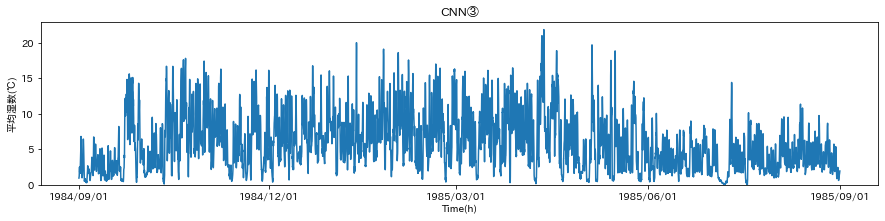

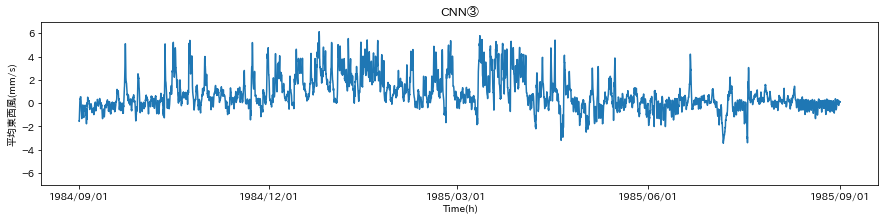

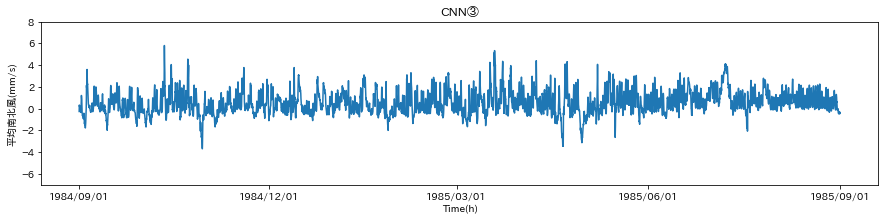

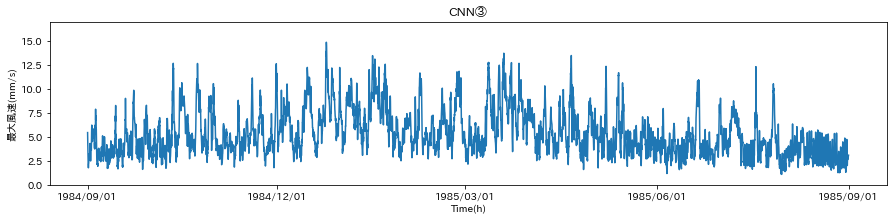

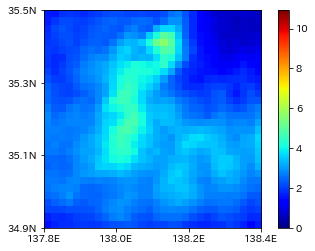

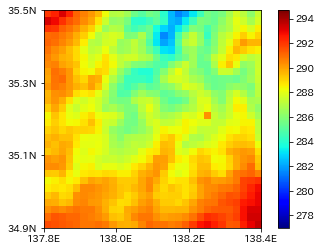

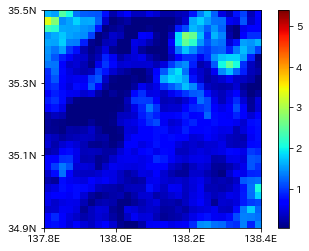

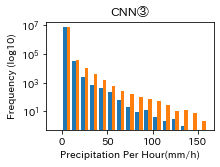

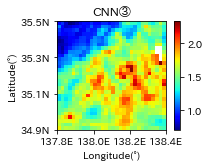

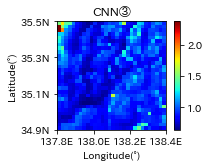

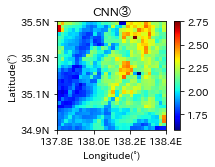

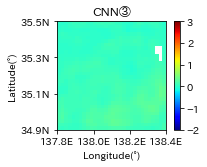

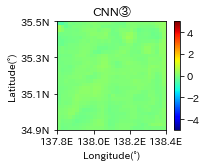

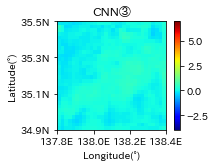

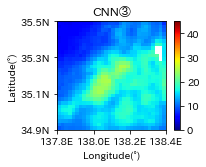

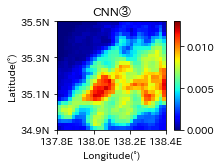

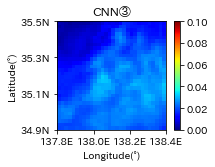

In [ ]:
# Residual Block
def res_block(input):
  z = Conv2D(64, 3, padding='same', kernel_initializer=initializer)(input)
  z = BatchNormalization(axis=-1)(z)
  z = PReLU()(z)
  z = Conv2D(64, 3, padding='same', kernel_initializer=initializer)(z)
  z = BatchNormalization(axis=-1)(z)
  return add([input, z])

# SE Block
def se_block(in_block, ch, r=16):
  z = GlobalAveragePooling2D()(in_block)
  z = Dense(ch//r, activation='relu')(z)
  z = Dense(ch, activation='sigmoid')(z)
  return Multiply()([in_block, z])

# モデル構造の定義
inputs = Input(shape=(4500,))
convd = Reshape((5, 30, 30))(inputs)
convd = Permute((2,3,1))(convd)
convd = Conv2D(64, 3, padding='same', kernel_initializer=initializer)(convd)
convd = PReLU()(convd)
z = res_block(convd)
z = se_block(z, ch=64)
z = res_block(z)
z = se_block(z, ch=64)
# z = res_block(z)
# z = se_block(z, ch=64)
z = Conv2D(64, 3, padding='same', kernel_initializer=initializer)(z)
z = BatchNormalization(axis=-1)(z)
z = add([convd, z])
z = Conv2D(64, 3, padding='same', kernel_initializer=initializer)(z)
z = PReLU()(z)
z = Conv2D(5, 3, padding='same', activation='linear', kernel_initializer=initializer)(z)
z = Permute((3,1,2))(z)
outputs = Reshape((4500,))(z)

# モデルのインスタンス化
set_seed(seed)
model = Model(inputs=inputs, outputs=outputs)

# モデルのコンパイル
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

# モデルの学習
callbacks = [EarlyStopping(patience=5, monitor='val_loss')]
set_seed(seed)
history = model.fit(x=x_train, y=y_train, epochs=200, callbacks=callbacks, validation_data=(x_val, y_val), batch_size=512)

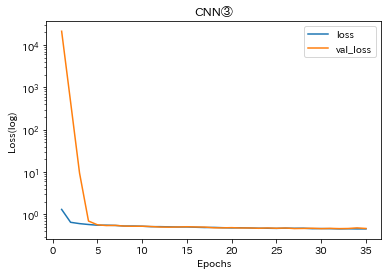

,Input,Pred
CORR_P,0.555495,0.626040
RMSE_CPT,1425.099121,1220.734985
RMSE_CPR,873.349365,709.989746
RMSE_XPT,2.156741,1.799012
RMSE_XPR,1.194064,1.001081
RMSE_999,18.523600,12.764807
RMSE_10,0.006348,0.002878
RMSE_4,0.011122,0.004253
RMSE_0.1,0.018648,0.437096
CORR_T,0.988171,0.996366


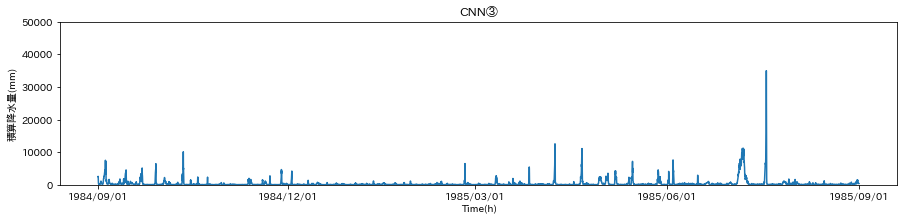

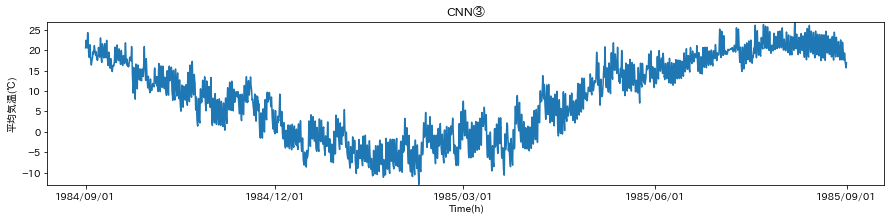

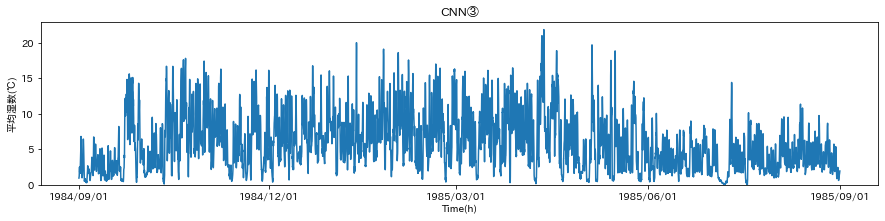

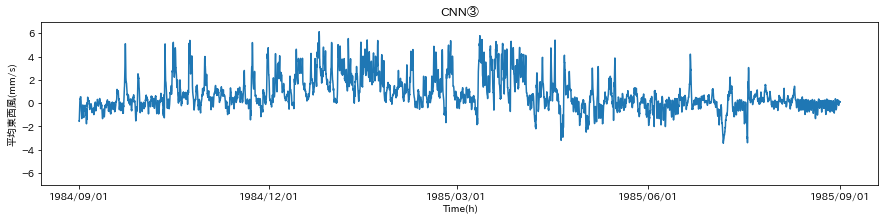

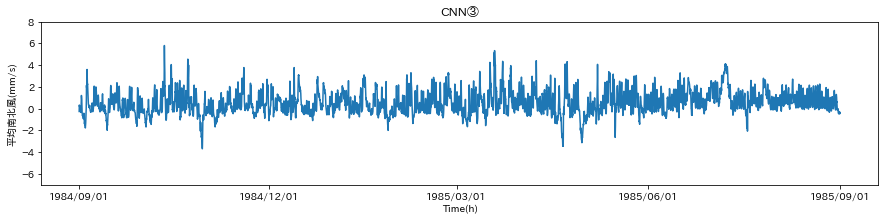

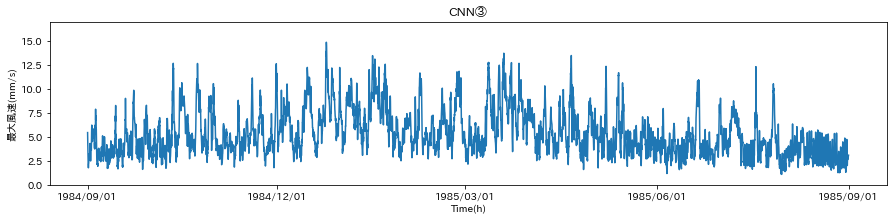

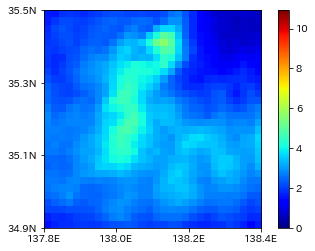

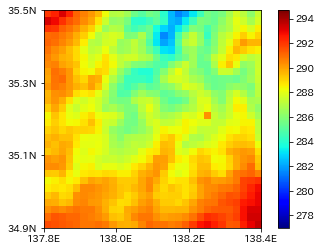

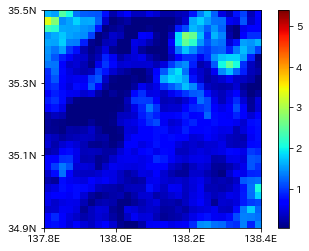

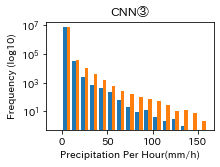

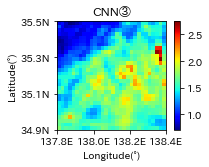

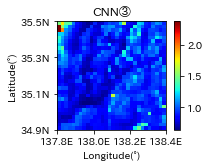

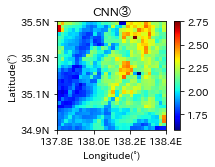

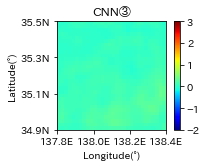

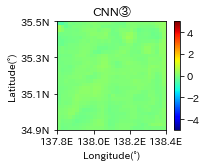

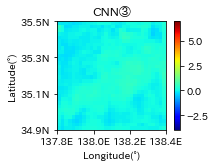

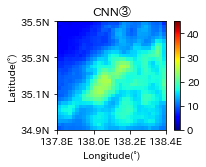

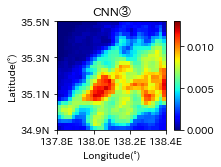

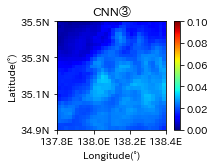

In [ ]:
# 推論
pred = np.transpose(ss_y.inverse_transform(np.transpose(model.predict(x_test).reshape((-1, 5, 900)), (0,2,1)).reshape((-1, 5))).reshape((-1, 900, 5)), (0,2,1)).reshape((-1,4500))
pred[:,900:] = x_pred[:,900:] - pred[:,900:]
pred[:,:900] = x_pred[:,:900] - np.cbrt(pred[:,:900]) + 150

# グラフのタイトル
title, net = 'CNN③', 'SE-SRResNet-diff'

# 学習の様子をプロット
plot_learning_process(title, history.history['loss'], history.history['val_loss'])

# 学習データの評価
result = Evaluation(x_pred, y_test, pred)
result('result_SE-SRResNet-diff.csv')

# グラフの表示
Graph(title, net, seed=seed)(pred, y_test)

In [ ]:
with open(f'{BASE_DIR}/results/SE-SRResNet.pickle', 'wb') as f:
  pickle.dump(pred, f)